# IMDB

The purpose of this notebook is to train a neural net on the imdb dataset to recognise positive and negative reviews.

We'll first import the imdb dataset.
num_words = 10000 means we'll only import the 10000 most frequently used words.

In [14]:
from keras.datasets import imdb

num_words = 10000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words = num_words)

Each of the data lists contain reviews. Each review is a list of word indices encoding a sequence of words.
The labels are 0s and 1s where 0s are negative and 1s are positive.

In [ ]:
print(train_data[0])
print(train_labels[0])

Note no word index will exceed 10000 due to num_words above:

In [ ]:
max([max(sequence) for sequence in train_data])

We can decode back to english (note index offset by 3 as 0,1 and 2 are used for padding, start of sequence and unknown.):

In [56]:
def decode_and_print(sequence):
    word_index = imdb.get_word_index()
    reverse_word_index = dict(
        [(value, key) for (key, value) in word_index.items()]
    )
    print(' '.join(
        reverse_word_index.get(i - 3, '?') for i in sequence
    ))
decode_and_print(train_data[0])

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

Now we've imported the data we'll need to convert it into tensors so we can feed them into the first layer of our net.
We'll turn our lists of words into a a vector of 0s and 1s. Setting indices of words in the sample to 1. Obviously this doesn't take word order into account, I'm assuming we'll get to that later...

In [27]:
import numpy as np

def vectorise_sequences(sequences, dimension = num_words):
    # Create an all-zero matrix with a column for each review and num_words rows.
    results = np.zeros((len(sequences),dimension))
    for i, sequence in enumerate(sequences):
        # We can set multiple indices in one operation by passing a list (sequence)
        results[i, sequence] = 1. # Note this is a float
    return results

x_train = vectorise_sequences(train_data)
x_test = vectorise_sequences(test_data)
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

Now vectorise out labels as well.

In [28]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

We're now ready to define our network.
Our input data are vectors. And the labels are scalars (1s and 0s).
This is the easiest setup we'll encounter (pretty much ever) and it'll work well with a stack of fully connected layers with relu activations.

The argument we'll pass to each layer is how many hidden units are in each layer. More units give the network more degrees of freedom to solve the problem which may be needed for more complex problems.
This does increase computaitonal intensivity and may leed to over-fitting.

There are two key decisions in the architecture of a stack of __Dense__ layers:
- How many layers to use
- How many hidden units to choose for each layer

We'll learn how to choose, but for now we'll use 2 intermediary layers with 16 each, and a third layer with a scalar prediction.

A relu function is:
y = x for x > 0
y = 0 for x <= 0

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import math
%matplotlib inline
x = np.arange(-2, 2, 0.05)
y = np.arange(-2, 2, 0.05)
y[:40] = 0
y[40:] = x [40:]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(x,y)

Let's define our model.

In [41]:
from keras import models, layers

model = models.Sequential()
model.add(layers.Dense(16, activation = 'relu', input_shape = (10000, )))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

2022-10-21 20:26:07.522418: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2022-10-21 20:26:07.522473: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: mantle
2022-10-21 20:26:07.522479: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: mantle
2022-10-21 20:26:07.522578: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 520.56.6
2022-10-21 20:26:07.522599: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.76.0
2022-10-21 20:26:07.522605: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 515.76.0 does not match DSO version 520.56.6 -- cannot find working devices in this configuration
2022-10-21 20:26:07.523074: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow bin

We'll now choose our loss funciton and optimiser.

Because this is a binary classification and the output is a probability we'll use `binary_crossentropy` loss.
We'll use the rmsprop optimiser.

In [43]:
model.compile(
    optimizer = 'rmsprop',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

We're passing the optimizer and loss functions as strings because they're keras built-in functions.

We could pass custom functions of class optimiser, losses and metric if we wanted to have more control.

We'll now split our training data into an initial training set and a validaiton set.
This'll allow us to gauge model acuracy on training data it hasn't seen before.

In [44]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
# Do the same for labels.
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

Now we'll train out model.

In [46]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs = 20,
    batch_size = 512,
    validation_data = (x_val, y_val)
)

Epoch 1/20
30/30 [==============================] - 2s 38ms/step - loss: 0.4858 - accuracy: 0.8005 - val_loss: 0.3685 - val_accuracy: 0.8698
Epoch 2/20
30/30 [==============================] - 1s 23ms/step - loss: 0.2918 - accuracy: 0.9043 - val_loss: 0.3025 - val_accuracy: 0.8842
Epoch 3/20
30/30 [==============================] - 1s 21ms/step - loss: 0.2160 - accuracy: 0.9283 - val_loss: 0.2851 - val_accuracy: 0.8862
Epoch 4/20
30/30 [==============================] - 1s 21ms/step - loss: 0.1690 - accuracy: 0.9462 - val_loss: 0.2868 - val_accuracy: 0.8846
Epoch 5/20
30/30 [==============================] - 1s 22ms/step - loss: 0.1376 - accuracy: 0.9556 - val_loss: 0.2933 - val_accuracy: 0.8842
Epoch 6/20
30/30 [==============================] - 1s 22ms/step - loss: 0.1123 - accuracy: 0.9656 - val_loss: 0.3951 - val_accuracy: 0.8532
Epoch 7/20
30/30 [==============================] - 1s 21ms/step - loss: 0.0916 - accuracy: 0.9747 - val_loss: 0.3446 - val_accuracy: 0.8737
Epoch 8/20
30

The call to fit has returned a `History` object. This contains a `history` which is a dict with information about the trianing progress per epoch. Let's plot it.

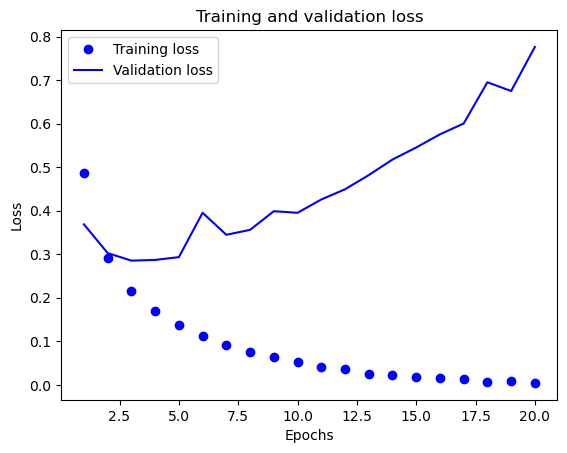

In [49]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss') # bo is blue dot.
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss') # b is blue line.
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

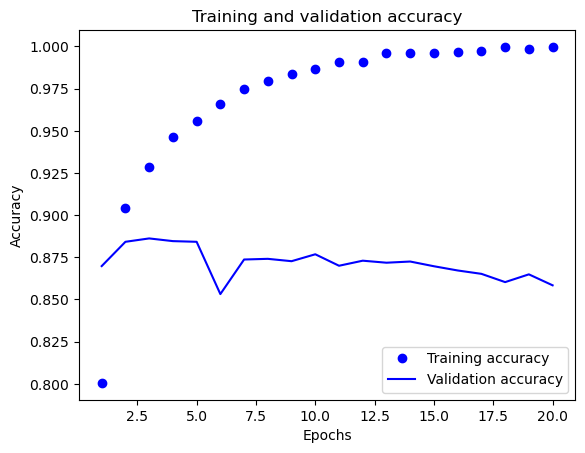

In [53]:
import matplotlib.pyplot as plt

history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy') # bo is blue dot.
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy') # b is blue line.
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

What we're seeing here is that the training loss decreases and training accuracy increases.

At the same time the validation accuracy doesn't actually increase. This suggests that whilst the model is being fit to the training data, it is not actually abstractly learning to classify the validation data.
The model is overfit to the training data.

Let's try again and run for 4 epochs (after which overfitting seems to occur).

In [54]:
model.fit(
    partial_x_train,
    partial_y_train,
    epochs = 4,
    batch_size = 512,
)
results = model.evaluate(x_test, y_test)

Epoch 1/4
30/30 [==============================] - 0s 14ms/step - loss: 0.0030 - accuracy: 0.9999
Epoch 2/4
30/30 [==============================] - 0s 16ms/step - loss: 0.0063 - accuracy: 0.9984
Epoch 3/4
30/30 [==============================] - 0s 15ms/step - loss: 0.0014 - accuracy: 0.9999
Epoch 4/4
782/782 [==============================] - 7s 9ms/step - loss: 0.9462 - accuracy: 0.8467


Our naive approach has yielded an accuracy of 84.6% which isn't great, but not terrible either.
We can now use the trained model to run predictions:

In [58]:
decode_and_print(test_data[0])
model.predict(x_test[0:1])

? please give this one a miss br br ? ? and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite ? so all you madison fans give this a miss
1/1 [==============================] - 0s 18ms/step


array([[0.00138812]], dtype=float32)